In [1]:
import sys
expected_env = "litter_decay"
python_path = sys.executable

assert expected_env in python_path, f"Notebook is not running in the expected environment: '{expected_env}'\n(sys.executable = {python_path})"

AssertionError: Notebook is not running in the expected environment: 'litter_decay'
(sys.executable = c:\Users\chak803\AppData\Local\mambaforge\envs\scicomp\python.exe)

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sol_ivp_ as svp
from scipy.interpolate import pchip_interpolate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score,root_mean_squared_error
import numpy as np
import shap
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance
from xgbtune import tune_xgb_model


In [50]:
palette = sns.color_palette()
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.edgecolor'] = (0.25, 0.25, 0.25)
plt.close('all')
# plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'png'

In [51]:
fixed_param, plant_data = svp.load_fix_par_and_data()

In [5]:
# Load and merge model-data, estimated parameters, and model performance dataframes for different N limitation strategies

df_estpar_local  = pd.read_excel('tables/df_estbar_local_merged.xlsx')


In [6]:
df_estpar_local.columns

Index(['Study', 'Species', 'Csource', 'MATC', 'C:N', 'carbohydrate_MMM',
       'protein_MMM', 'lignin_MMM', 'lipid_MMM', 'carbonyl_MMM', 'CUE0',
       'CUE_avg', 'DR0', 'DR_avg', 'vh_max', 'vp_max', 'vlig', 'vlip', 'vCr',
       'vh_max_se', 'vp_max_se', 'vlig_se', 'vlip_se', 'vCr_se', 'model',
       'Nlimitation_strategy', 'Climate', 'ID', 'carbohydrate_gC_r2',
       'protein_gC_r2', 'lignin_gC_r2', 'lipid_gC_r2', 'carbonyl_gC_r2',
       'carbohydrate_gC_rmse', 'protein_gC_rmse', 'lignin_gC_rmse',
       'lipid_gC_rmse', 'carbonyl_gC_rmse', 'overall_r2', 'overall_rmse'],
      dtype='object')

In [7]:
df_estpar_local.loc[df_estpar_local["Study"] == 'McKee et al., 2016', 'C:N'] = 44.3 / 1.47  # from McKee et al., 2016
df_estpar_local.loc[df_estpar_local["Study"] == 'Mathers et al., 2007', 'C:N'] = 45 # Mathers et al., 2007 10.1016/j.soilbio.2006.11.009

df_estpar_local.loc[(df_estpar_local["Study"] == 'Ono et al 2013') & ((df_estpar_local["Species"] == 'Beech_OFR')), 'C:N'] = 46.1 # Ono et al 2013
df_estpar_local.loc[(df_estpar_local["Study"] == 'Ono et al 2013') & ((df_estpar_local["Species"] == 'Oak_OFR')), 'C:N'] = 45.1 # Ono et al 2013
df_estpar_local.loc[(df_estpar_local["Study"] == 'Ono et al 2013') & ((df_estpar_local["Species"] == 'Beech_OFR')), 'C:N'] = 46.1 # Ono et al 2013
df_estpar_local.loc[(df_estpar_local["Study"] == 'Ono et al 2013') & ((df_estpar_local["Species"] == 'Cypress_TGR')), 'C:N'] = 57.4 # Ono et al 2013
df_estpar_local.loc[(df_estpar_local["Study"] == 'Ono et al 2013') & ((df_estpar_local["Species"] == 'Cedar_TKB')), 'C:N'] = 53.2 # Ono et al 2013
df_estpar_local[df_estpar_local['C:N'].isna()]

,Study,Species,Csource,MATC,C:N,carbohydrate_MMM,protein_MMM,lignin_MMM,lipid_MMM,carbonyl_MMM,...,lignin_gC_r2,lipid_gC_r2,carbonyl_gC_r2,carbohydrate_gC_rmse,protein_gC_rmse,lignin_gC_rmse,lipid_gC_rmse,carbonyl_gC_rmse,overall_r2,overall_rmse
81,Ono et al 2013,Birch_HTJ,leaf,21.0,NaN,0.346578,7.437667e-02,0.295563,0.281199,0.002283,...,0.925325,0.876203,NaN,0.010177,0.006408,0.010490,0.013117,NaN,0.976640,0.018298
82,Ono et al 2013,Oak_HTJ,leaf,21.0,NaN,0.441021,1.963589e-02,0.309132,0.228631,0.001580,...,0.965671,0.994986,NaN,0.004527,0.001211,0.007636,0.002281,NaN,0.998081,0.005145
87,Ono et al 2013,Chinquapin_MMY,leaf,21.0,NaN,0.468690,3.650881e-16,0.195671,0.335640,0.000000,...,0.993117,0.945374,NaN,0.003760,0.002771,0.002016,0.010636,NaN,0.996662,0.006838
170,Ono et al 2013,Birch_HTJ,leaf,21.0,NaN,0.346578,7.437667e-02,0.295563,0.281199,0.002283,...,0.923475,0.873843,NaN,0.009816,0.009388,0.010619,0.013241,NaN,0.976072,0.018520
171,Ono et al 2013,Oak_HTJ,leaf,21.0,NaN,0.441021,1.963589e-02,0.309132,0.228631,0.001580,...,0.905873,0.995272,NaN,0.005165,0.007797,0.012644,0.002215,NaN,0.994131,0.008996
176,Ono et al 2013,Chinquapin_MMY,leaf,21.0,NaN,0.468690,3.650881e-16,0.195671,0.335640,0.000000,...,0.984582,0.940818,NaN,0.007471,0.004492,0.003017,0.011071,NaN,0.993773,0.009338
259,Ono et al 2013,Birch_HTJ,leaf,21.0,NaN,0.346578,7.437667e-02,0.295563,0.281199,0.002283,...,0.919489,0.875308,NaN,0.009783,0.009545,0.010892,0.013164,NaN,0.975656,0.018680
260,Ono et al 2013,Oak_HTJ,leaf,21.0,NaN,0.441021,1.963589e-02,0.309132,0.228631,0.001580,...,0.921558,0.995773,NaN,0.004739,0.007817,0.011543,0.002094,NaN,0.993142,0.009725
265,Ono et al 2013,Chinquapin_MMY,leaf,21.0,NaN,0.468690,3.650881e-16,0.195671,0.335640,0.000000,...,0.984204,0.939652,NaN,0.005190,0.004580,0.003054,0.011179,NaN,0.994872,0.008474
348,Ono et al 2013,Birch_HTJ,leaf,21.0,NaN,0.346578,7.437667e-02,0.295563,0.281199,0.002283,...,0.922652,0.875159,NaN,0.009768,0.009564,0.010676,0.013172,NaN,0.975735,0.018650


In [8]:
# Create new DataFrame with rows where 'C:N' is not NaN
df_estpar_local_nonan = df_estpar_local.dropna(subset=['C:N'])
df_estpar_local_nonan

,Study,Species,Csource,MATC,C:N,carbohydrate_MMM,protein_MMM,lignin_MMM,lipid_MMM,carbonyl_MMM,...,lignin_gC_r2,lipid_gC_r2,carbonyl_gC_r2,carbohydrate_gC_rmse,protein_gC_rmse,lignin_gC_rmse,lipid_gC_rmse,carbonyl_gC_rmse,overall_r2,overall_rmse
0,Preston et al. 2009,Douglas-fir,needle,6.7,70.857143,0.432165,4.480287e-02,0.262780,0.242887,1.736456e-02,...,0.996599,0.963264,0.928522,0.007805,0.000134,0.002461,0.008156,0.000805,0.992392,0.005362
1,Preston et al. 2009,Tamarack,needle,6.7,82.711864,0.423048,3.838147e-02,0.341782,0.173363,2.342462e-02,...,0.964327,0.953016,0.686174,0.009434,0.000007,0.009161,0.005257,0.002286,0.988075,0.006640
2,Preston et al. 2009,Jack pine,needle,6.7,38.828125,0.502613,8.176040e-02,0.141812,0.272028,1.786450e-03,...,0.441398,0.966907,0.834274,0.031527,0.000398,0.024325,0.007546,0.002063,0.917528,0.018786
3,Preston et al. 2009,Black spruce,needle,6.7,67.808219,0.414226,4.681738e-02,0.291283,0.217379,3.029425e-02,...,0.997415,0.990462,0.977715,0.005295,0.000051,0.002364,0.003247,0.000696,0.997269,0.003093
4,Preston et al. 2009,Western redcedar,needle,6.7,77.656250,0.389091,4.088020e-02,0.303699,0.247825,1.850468e-02,...,0.983888,0.812876,0.804055,0.010944,0.003826,0.005206,0.014053,0.001043,0.979172,0.008724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,Ono et al 2013,Beech_OFR,leaf,21.0,46.100000,0.513151,6.514458e-16,0.263280,0.223568,0.000000e+00,...,0.569048,0.996626,NaN,0.005848,0.016401,0.021203,0.001658,NaN,0.978445,0.018349
707,Ono et al 2013,Oak_OFR,leaf,21.0,45.100000,0.394755,2.456707e-02,0.346631,0.232765,1.282293e-03,...,0.980574,0.975932,NaN,0.003439,0.017624,0.007126,0.005042,NaN,0.990283,0.011757
708,Ono et al 2013,Cypress_TGR,leaf,21.0,57.400000,0.371792,0.000000e+00,0.301408,0.326799,1.327388e-16,...,0.301110,0.974703,NaN,0.022190,0.005698,0.029537,0.008002,NaN,0.951865,0.024596
709,Ono et al 2013,Cedar_TKB,leaf,21.0,53.200000,0.391706,0.000000e+00,0.268543,0.339752,1.912262e-16,...,0.955422,0.951285,NaN,0.006973,0.004136,0.006293,0.010053,NaN,0.990588,0.011374


In [54]:
# Select predictors and targets
predictors = ['Climate', 'Csource', 'MATC', 'C:N', 'carbohydrate_MMM', 'protein_MMM', 'lignin_MMM', 'lipid_MMM', 'carbonyl_MMM']
# predictors = ['MATC', 'C:N']
predictors = ['MATC', 'C:N']

targets = ['vh_max', 'vp_max', 'vlig', 'vlip', 'vCr']
# print("X shape:", X.shape)
# print("y shape:", y.shape)
# print("Shapes match:", X.shape[0] == y.shape[0])

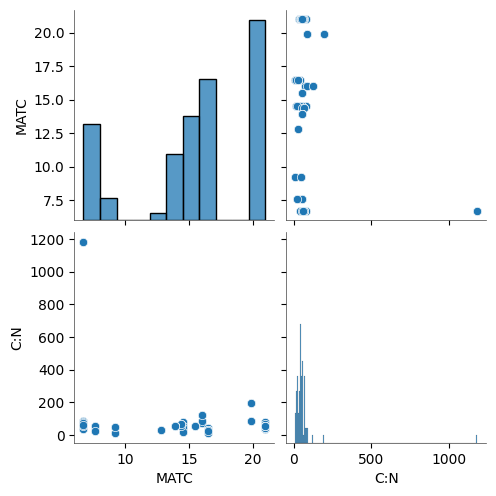

In [55]:
import seaborn as sns
sns.pairplot(df_estpar_local_nonan[predictors])

In [46]:
df_estpar_local_nonan['model'].unique()

array(['NPNE', 'NPWE', 'PWOE', 'PWOV'], dtype=object)

# test rf

Best params: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}
CV best R²: -3.184
Strategy N-Retention and model scenario PWOV Training: vh_max: R2 = 0.192,           Testing:  vh_max: R2 = -0.543
Best params: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
CV best R²: 0.169
Strategy N-Retention and model scenario PWOV Training: vp_max: R2 = 0.478,           Testing:  vp_max: R2 = -0.869
Best params: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}
CV best R²: -0.082
Strategy N-Retention and model scenario PWOV Training: vlig: R2 = 0.363,           Testing:  vlig: R2 = 0.573
Best params: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}
CV best R²: -0.713
Strategy N-Retention and model scenario PWOV Training: vlip: R2 = 0.285,           Testing:  vlip: R2 = -0.860
Best params: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, '

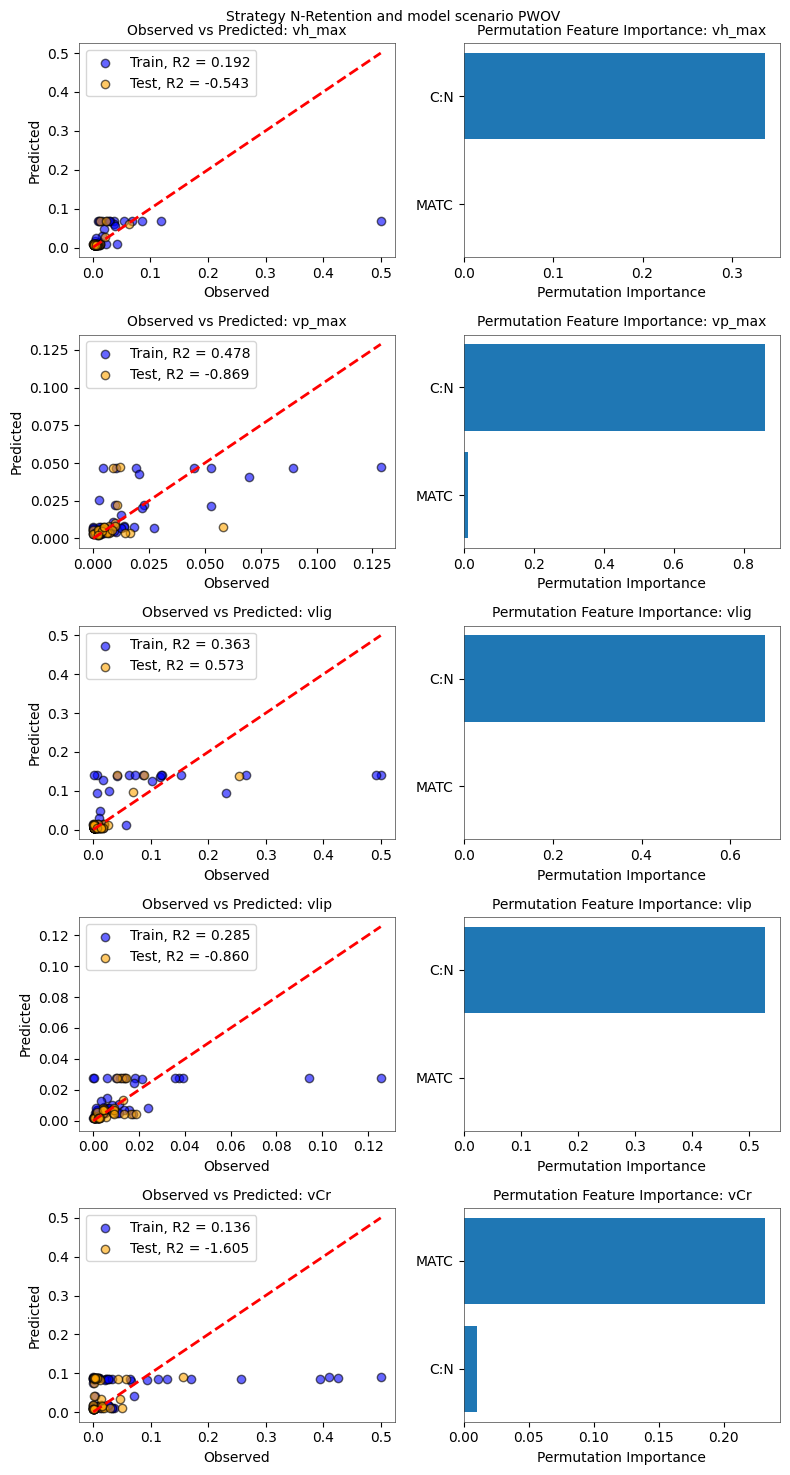

In [56]:

r2_records = []
importance_records = []
generate_plot=True

strategy ='N-Retention';modelname = 'PWOV'
df_sub = df_estpar_local_nonan[(df_estpar_local_nonan['Nlimitation_strategy'] == strategy)&(df_estpar_local_nonan['model'] == modelname)].copy()
df_sub = df_sub[predictors+targets].copy()
df_sub

X = df_sub[predictors]
y = df_sub[targets]
# Handle categorical variables
cat_cols = ['Climate']
# num_cols = [col for col in predictors if col not in cat_cols]
# X_encoded = pd.get_dummies(X, drop_first=True, columns=cat_cols)
X_encoded = X

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
# y_train = y
# X_train=X_encoded.copy()
if generate_plot:
    fig, axes = plt.subplots(5, 2, figsize=(8, 3*5))

# Loop over targets
for j, target in enumerate(targets):
    rf = RandomForestRegressor(random_state=42)
    # rf.fit(X_train, y_train[target])

    param_grid = {
        'max_depth': [5, 10, 20, None],
        'min_samples_leaf': [1, 5, 10],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [100, 200]
    }
    
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train[target])
    rf = grid_search.best_estimator_

    print(f"Best params: {grid_search.best_params_}")
    print(f"CV best R²: {grid_search.best_score_:.3f}")


    # Predictions
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    r2_train = r2_score(y_train[target], y_pred_train)
    r2_test = r2_score(y_test[target], y_pred_test)

    # --- Save R² ---
    r2_records.append({
        "strategy": strategy,
        "modelname": modelname,
        "target": target,
        "R2_train": r2_train,
        "R2_test": r2_test
    })
    
    # Print R²
    print(f"Strategy {strategy} and model scenario {modelname} Training: {target}: R2 = {r2_score(y_train[target], y_pred_train):.3f}, \
          Testing:  {target}: R2 = {r2_score(y_test[target], y_pred_test):.3f}")

    # Compute SHAP values
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer(X_train)
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    for feat, val in zip(X_train.columns, mean_abs_shap):
        importance_records.append({
            "strategy": strategy,
            "modelname": modelname,
            "target": target,
            "feature": feat,
            "importance_type": "SHAP",
            "importance_value": val
        })
    # Figure with two panels
    if generate_plot:
        # === Left: Observed vs Predicted for train & test ===
        axes[j,0].scatter(y_train[target], y_pred_train, alpha=0.6, edgecolor="k", label=f"Train, R2 = {r2_score(y_train[target], rf.predict(X_train)):.3f}", color="blue")
        axes[j,0].scatter(y_test[target], y_pred_test, alpha=0.6, edgecolor="k", label=f"Test, R2 = {r2_score(y_test[target], rf.predict(X_test)):.3f}", color="orange")

        # 1:1 line
        all_obs = y[target]
        all_pred = y_pred_train
        lims = [min(all_obs.min(), all_pred.min()), max(all_obs.max(), all_pred.max())]
        axes[j,0].plot(lims, lims, 'r--', lw=2)

        axes[j,0].set_xlabel("Observed")
        axes[j,0].set_ylabel("Predicted")
        axes[j,0].set_title(f"Observed vs Predicted: {target}")
        axes[j,0].legend()


    # === Right: SHAP bar plot ===
    # shap.plots.bar(
    #     shap_values,
    #     # X_train if isinstance(X_encoded, np.ndarray) else X_train[feature_names],
    #     max_display=15,
    #     show=False,
    #     ax=axes[j,1]  # <- pass target axes here,
    # )

    result = permutation_importance(rf, X_train, y_train[target], n_repeats=30, random_state=42)
    importances = result.importances_mean
    stds = result.importances_std
    indices = importances.argsort()
    if generate_plot:
        axes[j, i].barh(X_train.columns[indices], importances[indices])
        axes[j, i].set_xlabel("Permutation Importance")
        axes[j, i].set_title(f"Permutation Feature Importance: {target}")
            
        for i in [0,1]:
            axes[j,i].tick_params(axis='both', labelsize=10)         # tick labels font size
            axes[j,i].xaxis.label.set_size(10)                       # x-axis label font size
            axes[j,i].yaxis.label.set_size(10)                       # y-axis label font size
            axes[j,i].title.set_size(10)                             # title font size

    for feat, val in zip(X_train.columns, importances):
        importance_records.append({
            "strategy": strategy,
            "modelname": modelname,
            "target": target,
            "feature": feat,
            "importance_type": "Permutation",
            "importance_value": val
        })
plt.suptitle(f"Strategy {strategy} and model scenario {modelname} ", fontsize=10)
plt.tight_layout()
# plt.savefig(f"figs/rf_model_{strategy}_{modelname}.png", dpi=300, bbox_inches='tight')


# Convert to DataFrames
df_r2 = pd.DataFrame(r2_records)
df_importance = pd.DataFrame(importance_records)


# try XGBoost

tuning pass 0...
computing best round...
best round: 1
tuning max_depth and min_child_weight ...
best loss: 0.0394
best max_depth: 5
best min_child_weight: 1
tuning gamma ...
best loss: 0.0394
best gamma: 0.0
re-computing best round...
best round: 1
tuning subsample and colsample_bytree ...
best loss: 0.0394
best subsample: 1.0
best colsample_bytree: 0.6
fine tuning subsample and colsample_bytree ...
best loss: 0.0394
best subsample: 1.0
best colsample_bytree: 0.6
tuning alpha and lambda ...
best loss: 0.0394
best alpha: 0
best lambda: 1
tuning seed ...
best loss: 0.0394
best seed: 0
{'eval_metric': 'rmsle', 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 1.0, 'colsample_bytree': 0.6, 'alpha': 0, 'lambda': 1, 'seed': 0}
tuning pass 1...
computing best round...
best round: 2
tuning max_depth and min_child_weight ...
best loss: 0.0324
best max_depth: 8
best min_child_weight: 1
tuning gamma ...
best loss: 0.0324
best gamma: 0.0
re-computing best round...
best round: 2
tu

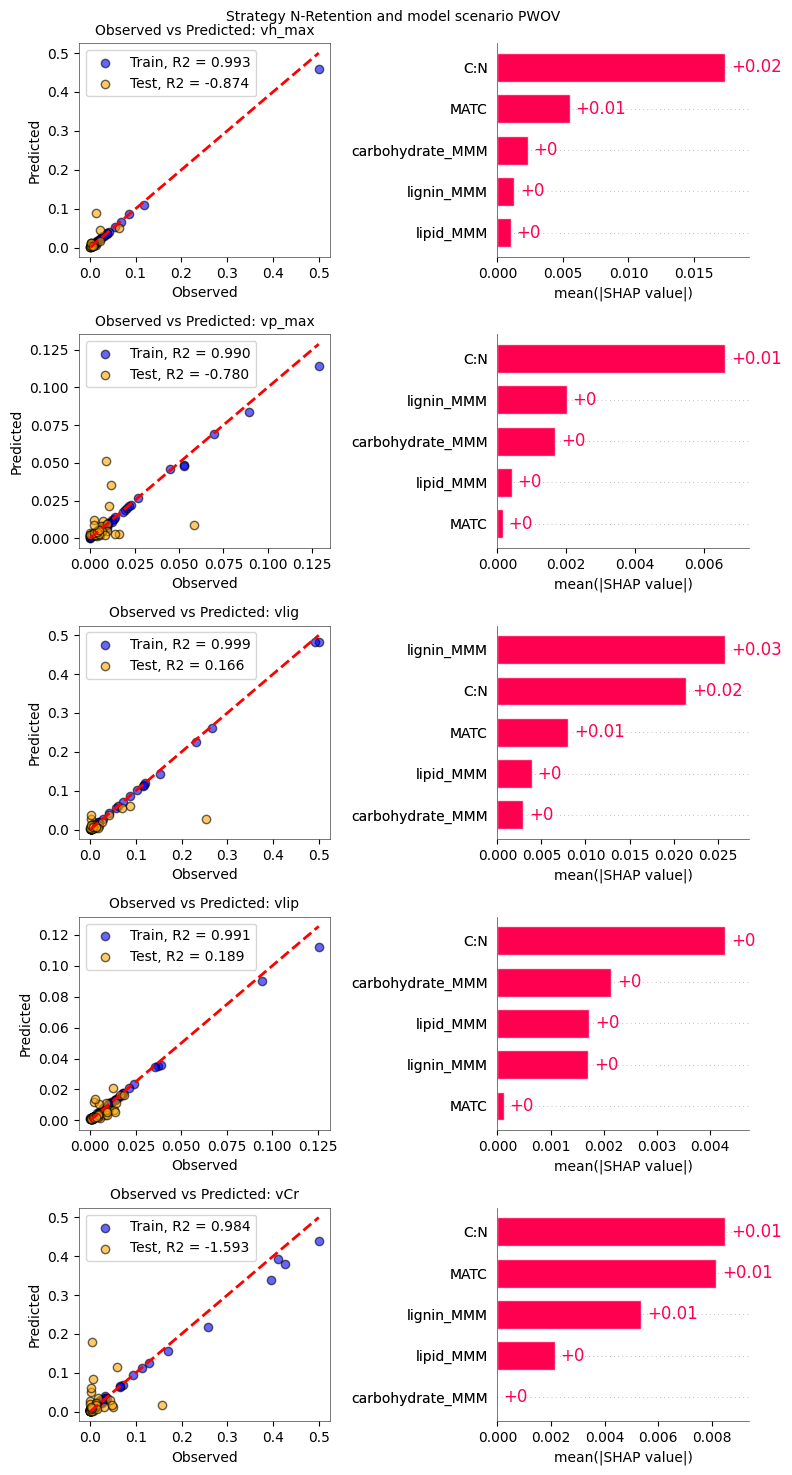

In [52]:
generate_plot= True
grid_search=True
r2_records = []
importance_records = []

strategy ='N-Retention';modelname = 'PWOV'
df_sub = df_estpar_local_nonan[(df_estpar_local_nonan['Nlimitation_strategy'] == strategy)&(df_estpar_local_nonan['model'] == modelname)].copy()
df_sub = df_sub[predictors+targets].copy()
df_sub

X = df_sub[predictors]
y = df_sub[targets]
# Handle categorical variables
cat_cols = ['Climate']
# num_cols = [col for col in predictors if col not in cat_cols]
# X_encoded = pd.get_dummies(X, drop_first=True, columns=cat_cols)
X_encoded = X

if generate_plot:
    fig, axes = plt.subplots(5, 2, figsize=(8, 3*5))
# Loop over targets
for j, target in enumerate(targets):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y[target], test_size=0.3, random_state=42)

    dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)
    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    params = {'eval_metric': 'rmsle'}
    if grid_search:
        params, round_count = tune_xgb_model(params, X_train, y_train)
    else:
        params = {
            "objective": "reg:squarederror",
            "tree_method": "hist"
            }
    # Define hyperparameters
    # params = {"objective": "reg:squarederror", "tree_method": "hist"}

    n = 5000
    model = xgb.train(
        params=params,
        dtrain=dtrain_reg,
        num_boost_round=n,
        evals=evals,
        verbose_eval=10,
        # Activate early stopping
        early_stopping_rounds=10
    )     

    y_pred_train = model.predict(dtrain_reg)
    y_pred_test = model.predict(dtest_reg)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # --- Save R² ---
    r2_records.append({
        "strategy": strategy,
        "modelname": modelname,
        "target": target,
        "R2_train": r2_train,
        "R2_test": r2_test
    })
    
    # Print R²
    print(f"Strategy {strategy} and model scenario {modelname} Training: {target}: R2 = {r2_score(y_train, y_pred_train):.3f}, \
          Testing:  {target}: R2 = {r2_score(y_test, y_pred_test):.3f}")

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_train)
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    for feat, val in zip(X_train.columns, mean_abs_shap):
        importance_records.append({
            "strategy": strategy,
            "modelname": modelname,
            "target": target,
            "feature": feat,
            "importance_type": "SHAP",
            "importance_value": val
        })
    # Figure with two panels
    if generate_plot:
        # === Left: Observed vs Predicted for train & test ===
        axes[j,0].scatter(y_train, y_pred_train, alpha=0.6, edgecolor="k", label=f"Train, R2 = {r2_train:.3f}", color="blue")
        axes[j,0].scatter(y_test, y_pred_test, alpha=0.6, edgecolor="k", label=f"Test, R2 = {r2_test:.3f}", color="orange")

        # 1:1 line
        all_obs = y_train
        all_pred = y_pred_train
        lims = [min(all_obs.min(), all_pred.min()), max(all_obs.max(), all_pred.max())]
        axes[j,0].plot(lims, lims, 'r--', lw=2)

        axes[j,0].set_xlabel("Observed")
        axes[j,0].set_ylabel("Predicted")
        axes[j,0].set_title(f"Observed vs Predicted: {target}")
        axes[j,0].legend()
        
        # fig, ax = plt.subplots(figsize=(8,6))
        # plot_importance(model, max_num_features=20, ax=ax)
        
        # === Right: SHAP bar plot ===
        shap.plots.bar(
            shap_values,
            # X_train if isinstance(X_encoded, np.ndarray) else X_train[feature_names],
            max_display=15,
            show=False,
            ax=axes[j,1]  # <- pass target axes here,
        )         
        for i in [0,1]:
            axes[j,i].tick_params(axis='both', labelsize=10)         # tick labels font size
            axes[j,i].xaxis.label.set_size(10)                       # x-axis label font size
            axes[j,i].yaxis.label.set_size(10)                       # y-axis label font size
            axes[j,i].title.set_size(10)                             # title font size


    importances = model.get_score(importance_type='weight')
    for feat, val in importances.items():
        importance_records.append({
            "strategy": strategy,
            "modelname": modelname,
            "target": target,
            "feature": feat,
            "importance_type": "xGboost",
            "importance_value": val
        })
plt.suptitle(f"Strategy {strategy} and model scenario {modelname} ", fontsize=10)
plt.tight_layout()
# plt.savefig(f"figs/rf_model_{strategy}_{modelname}.png", dpi=300, bbox_inches='tight')


# Convert to DataFrames
df_r2 = pd.DataFrame(r2_records)
df_importance = pd.DataFrame(importance_records)

In [23]:
importance_dict.items()

dict_items([('MATC', 51.0), ('C:N', 81.0), ('carbohydrate_MMM', 46.0), ('protein_MMM', 33.0), ('lignin_MMM', 28.0), ('lipid_MMM', 37.0)])

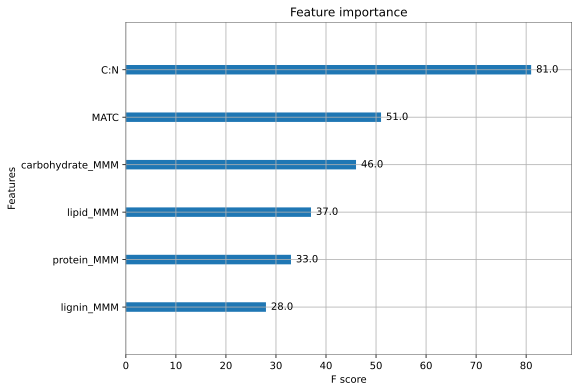

MATC 51.0
C:N 81.0
carbohydrate_MMM 46.0
protein_MMM 33.0
lignin_MMM 28.0
lipid_MMM 37.0


[{'strategy': 'N-Retention',
  'modelname': 'PWOV',
  'target': 'vh_max',
  'feature': 'MATC',
  'importance_type': 'xGboost',
  'importance_value': 51.0},
 {'strategy': 'N-Retention',
  'modelname': 'PWOV',
  'target': 'vh_max',
  'feature': 'C:N',
  'importance_type': 'xGboost',
  'importance_value': 81.0},
 {'strategy': 'N-Retention',
  'modelname': 'PWOV',
  'target': 'vh_max',
  'feature': 'carbohydrate_MMM',
  'importance_type': 'xGboost',
  'importance_value': 46.0},
 {'strategy': 'N-Retention',
  'modelname': 'PWOV',
  'target': 'vh_max',
  'feature': 'protein_MMM',
  'importance_type': 'xGboost',
  'importance_value': 33.0},
 {'strategy': 'N-Retention',
  'modelname': 'PWOV',
  'target': 'vh_max',
  'feature': 'lignin_MMM',
  'importance_type': 'xGboost',
  'importance_value': 28.0},
 {'strategy': 'N-Retention',
  'modelname': 'PWOV',
  'target': 'vh_max',
  'feature': 'lipid_MMM',
  'importance_type': 'xGboost',
  'importance_value': 37.0}]

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
plot_importance(model, max_num_features=20, ax=ax)
plt.show()
importance_dict = model.get_score(importance_type='weight')
importance_records=[]
for feat, val in importance_dict.items():
    print(feat, val)
    importance_records.append({
        "strategy": strategy,
        "modelname": modelname,
        "target": target,
        "feature": feat,
        "importance_type": "xGboost",
        "importance_value": val
    })

# importance_dict

importance_records
# importance_records

# run RF for all combinations of strategies and models

In [ ]:
r2_records = []
importance_records = []
generate_plot=False

for strategy in df_estpar_local_nonan['Nlimitation_strategy'].unique():
    for modelname in df_estpar_local_nonan['model'].unique():
        df_sub = df_estpar_local_nonan[(df_estpar_local_nonan['Nlimitation_strategy'] == strategy)&(df_estpar_local_nonan['model'] == modelname)].copy()
        df_sub = df_sub[predictors+targets].copy()
        df_sub

        X = df_sub[predictors]
        y = df_sub[targets]
        # Handle categorical variables
        cat_cols = ['Climate']
        # num_cols = [col for col in predictors if col not in cat_cols]
        # X_encoded = pd.get_dummies(X, drop_first=True, columns=cat_cols)
        X_encoded = X

        # Train/test split
        # X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.0, random_state=42)
        y_train = y
        X_train=X_encoded.copy()
        if generate_plot:
            fig, axes = plt.subplots(5, 2, figsize=(8, 3*5))

        # Loop over targets
        for j, target in enumerate(targets):
            rf = RandomForestRegressor(n_estimators=100, random_state=420)
            rf.fit(X_train, y_train[target])

            # Predictions
            y_pred_train = rf.predict(X_train)
            r2_train = r2_score(y_train[target], y_pred_train)
            # --- Save R² ---
            r2_records.append({
                "strategy": strategy,
                "modelname": modelname,
                "target": target,
                "R2_train": r2_train
            })
            # y_pred_test = rf.predict(X_test)

            # Print R²
            # print(f"Testing:  {target}: R2 = {r2_score(y_test[target], y_pred_test):.3f}")
            print(f"Strategy {strategy} and model scenario {modelname} Training: {target}: R2 = {r2_score(y_train[target], y_pred_train):.3f}")

            # Compute SHAP values
            explainer = shap.TreeExplainer(rf)
            shap_values = explainer(X_train)
            mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

            for feat, val in zip(X_train.columns, mean_abs_shap):
                importance_records.append({
                    "strategy": strategy,
                    "modelname": modelname,
                    "target": target,
                    "feature": feat,
                    "importance_type": "SHAP",
                    "importance_value": val
                })
            # Figure with two panels
            if generate_plot:
                # === Left: Observed vs Predicted for train & test ===
                axes[j,0].scatter(y_train[target], y_pred_train, alpha=0.6, edgecolor="k", label=f"Train, R2 = {r2_score(y_train[target], rf.predict(X_train)):.3f}", color="blue")
                # axes[0].scatter(y_test[target], y_pred_test, alpha=0.6, edgecolor="k", label="Test", color="orange")

                # 1:1 line
                all_obs = y_train[target]
                all_pred = y_pred_train
                lims = [min(all_obs.min(), all_pred.min()), max(all_obs.max(), all_pred.max())]
                axes[j,0].plot(lims, lims, 'r--', lw=2)

                axes[j,0].set_xlabel("Observed")
                axes[j,0].set_ylabel("Predicted")
                axes[j,0].set_title(f"Observed vs Predicted: {target}")
                axes[j,0].legend()


            # === Right: SHAP bar plot ===
            # shap.plots.bar(
            #     shap_values,
            #     # X_train if isinstance(X_encoded, np.ndarray) else X_train[feature_names],
            #     max_display=15,
            #     show=False,
            #     ax=axes[j,1]  # <- pass target axes here,
            # )

            result = permutation_importance(rf, X_train, y[target], n_repeats=30, random_state=42)
            importances = result.importances_mean
            stds = result.importances_std
            indices = importances.argsort()
            if generate_plot:
                axes[j, i].barh(X_train.columns[indices], importances[indices])
                axes[j, i].set_xlabel("Permutation Importance")
                axes[j, i].set_title(f"Permutation Feature Importance: {target}")
                    
                for i in [0,1]:
                    axes[j,i].tick_params(axis='both', labelsize=10)         # tick labels font size
                    axes[j,i].xaxis.label.set_size(10)                       # x-axis label font size
                    axes[j,i].yaxis.label.set_size(10)                       # y-axis label font size
                    axes[j,i].title.set_size(10)                             # title font size

            for feat, val in zip(X_train.columns, importances):
                importance_records.append({
                    "strategy": strategy,
                    "modelname": modelname,
                    "target": target,
                    "feature": feat,
                    "importance_type": "Permutation",
                    "importance_value": val
                })
        # plt.suptitle(f"Strategy {strategy} and model scenario {modelname} ", fontsize=10)
        # plt.tight_layout()
        # plt.savefig(f"figs/rf_model_{strategy}_{modelname}.png", dpi=300, bbox_inches='tight')


# Convert to DataFrames
df_r2 = pd.DataFrame(r2_records)
df_importance = pd.DataFrame(importance_records)


In [ ]:
df_r2

In [ ]:
df_importance